In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame 
import nltk

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv("data/user_reviews.csv")

In [4]:
# print(df.columns)
# print(df.shape)


#del df['Unnamed: 0']


if 'Unnamed: 0' in df.columns:
    del df['Unnamed: 0']
else:
    exit
df.columns


Index(['asin', 'helpful', 'overall', 'productid', 'reviewText', 'reviewTime',
       'reviewerID', 'reviewerName', 'summary', 'unixReviewTime'],
      dtype='object')

In [5]:
df.head()

,asin,helpful,overall,productid,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00APT3MHO,"[0, 0]",5.0,1,Good for someone who likes skinny jeans but do...,"11 17, 2013",A1JWX45KHE34AL,varnienarsil,Love these jeans,1384646400
1,B00CJ5NH36,"[0, 0]",5.0,2,This shirt with it's bold graphic is seriously...,"11 17, 2013",A1JWX45KHE34AL,varnienarsil,As cute as it looks,1384646400
2,B00F9NGAPM,"[1, 1]",3.0,4,The shirt is a little flowy-er than I expected...,"11 17, 2013",A1JWX45KHE34AL,varnienarsil,"Like, don't love",1384646400
3,B000LYFF46,"[0, 0]",3.0,5,"I selected &#34;fit as expected&#34;, but they...","03 3, 2014",A2YHF6O2D37PMX,DCP,Just not comfortable for me,1393804800
4,B005FPAC8K,"[3, 3]",1.0,6,May 27: I've worn them 3-4 times each since M...,"05 7, 2012",A2YHF6O2D37PMX,DCP,Lowered my rating,1336348800


### Product based CF

In [6]:
count = df.groupby("asin", as_index=False).count()
mean = df.groupby("asin", as_index=False).mean()

dfMerged = pd.merge(df, count, how='right', on=['asin'])
dfMerged

,asin,helpful_x,overall_x,productid_x,reviewText_x,reviewTime_x,reviewerID_x,reviewerName_x,summary_x,unixReviewTime_x,helpful_y,overall_y,productid_y,reviewText_y,reviewTime_y,reviewerID_y,reviewerName_y,summary_y,unixReviewTime_y
0,B00APT3MHO,"[0, 0]",5.0,1,Good for someone who likes skinny jeans but do...,"11 17, 2013",A1JWX45KHE34AL,varnienarsil,Love these jeans,1384646400,2,2,2,2,2,2,2,2,2
1,B00APT3MHO,"[0, 0]",3.0,1,I have never owned or tried on Cheap Monday je...,"08 10, 2013",A1IH8PZXP8B29W,KT,Runs small,1376092800,2,2,2,2,2,2,2,2,2
2,B00CJ5NH36,"[0, 0]",5.0,2,This shirt with it's bold graphic is seriously...,"11 17, 2013",A1JWX45KHE34AL,varnienarsil,As cute as it looks,1384646400,1,1,1,1,1,1,1,1,1
3,B00F9NGAPM,"[1, 1]",3.0,4,The shirt is a little flowy-er than I expected...,"11 17, 2013",A1JWX45KHE34AL,varnienarsil,"Like, don't love",1384646400,1,1,1,1,1,1,1,1,1
4,B000LYFF46,"[0, 0]",3.0,5,"I selected &#34;fit as expected&#34;, but they...","03 3, 2014",A2YHF6O2D37PMX,DCP,Just not comfortable for me,1393804800,11,11,11,11,11,11,11,11,11
5,B000LYFF46,"[0, 0]",2.0,5,"Quality was ok, Leather seemed a bit stiff. ...","12 12, 2013",A29U2XOQE3CPFM,"Merfis ""Book Lover""",Run a bit small.,1386806400,11,11,11,11,11,11,11,11,11
6,B000LYFF46,"[1, 1]",4.0,5,"These shoes are very comfortable, but a little...","06 9, 2014",A3UURWMLH2MG06,Rachel Cosper,"8 is tight, but 8.5 would be too big",1402272000,11,11,11,11,11,11,11,11,11
7,B000LYFF46,"[1, 1]",3.0,5,The instep area is too wide/deep for a narrow....,"03 28, 2014",ATSN26HP5S0ZK,jlm,Instep area too deep for narrow foot,1395964800,11,11,11,11,11,11,11,11,11
8,B000LYFF46,"[2, 2]",5.0,5,Ok what more can I say than perfect. Bought AL...,"03 31, 2014",A2UP9MFSG6XU9B,"dls74447 ""Diane""",My fav. go to shoe.,1396224000,11,11,11,11,11,11,11,11,11
9,B000LYFF46,"[0, 0]",5.0,5,I am buying shoes for comfort and good looks a...,"01 2, 2014",A2H1PDX22BPBP9,"Annalee J. Gregory ""shopper""",Great Comfort Shoe,1388620800,11,11,11,11,11,11,11,11,11


In [7]:
#rename column
dfMerged["totalReviewers"] = dfMerged["reviewerID_y"]
dfMerged["overallScore"] = dfMerged["overall_x"]
dfMerged["summaryReview"] = dfMerged["summary_x"]

dfNew = dfMerged[['asin','summaryReview','overallScore',"totalReviewers"]]

dfNew.head()

,asin,summaryReview,overallScore,totalReviewers
0,B00APT3MHO,Love these jeans,5.0,2
1,B00APT3MHO,Runs small,3.0,2
2,B00CJ5NH36,As cute as it looks,5.0,1
3,B00F9NGAPM,"Like, don't love",3.0,1
4,B000LYFF46,Just not comfortable for me,3.0,11


Selecting products which have more than 50 reviews

In [8]:
dfMerged = dfMerged.sort_values(by='totalReviewers', ascending=False)
dfCount = dfMerged[dfMerged.totalReviewers >= 40]
dfCount.head()

,asin,helpful_x,overall_x,productid_x,reviewText_x,reviewTime_x,reviewerID_x,reviewerName_x,summary_x,unixReviewTime_x,...,productid_y,reviewText_y,reviewTime_y,reviewerID_y,reviewerName_y,summary_y,unixReviewTime_y,totalReviewers,overallScore,summaryReview
569,B0058XIMMM,"[0, 0]",5.0,95,"Well, these are not quite ready for runway fas...","01 19, 2014",AXKYW1ENCMYMA,carrie jean queen,Believe,1390089600,...,250,250,250,250,250,250,250,250,5.0,Believe
636,B0058XIMMM,"[0, 0]",5.0,95,I am in love with these shoes. They are the re...,"12 3, 2013",A1F4HF9WH15R3C,SlyMomma,GoWalk = Awesome,1386028800,...,250,250,250,250,250,250,250,250,5.0,GoWalk = Awesome
626,B0058XIMMM,"[0, 0]",5.0,95,"So comfortable, light & go with everything! I ...","05 16, 2014",A2PB9HQUPE8E0J,KAREN,Love these Sketchers!!,1400198400,...,250,250,250,250,250,250,250,250,5.0,Love these Sketchers!!
627,B0058XIMMM,"[0, 0]",5.0,95,These shoes are so lightweight and airy that i...,"09 26, 2012",A3C3WPL68929SB,"Iggylil ""IG Lover""",Barefoot But With Support,1348617600,...,250,250,250,250,250,250,250,250,5.0,Barefoot But With Support
628,B0058XIMMM,"[0, 0]",5.0,95,THIS SHOE IS SO LIGHT AND GREAT ON MY FEET. L...,"10 6, 2012",A3IYWLLRWHZBNO,Smiley,wonderful,1349481600,...,250,250,250,250,250,250,250,250,5.0,wonderful


### Grouping all the summary Reviews by product ID

In [9]:
dfProductReview = df.groupby("asin", as_index=False).mean()
ProductReviewSummary = dfCount.groupby("asin")["summaryReview"].apply(list)
ProductReviewSummary = pd.DataFrame(ProductReviewSummary)
ProductReviewSummary.to_csv("ProductReviewSummary.csv")

In [10]:
dfProductReview.head()

# ProductReviewSummary.head()

,asin,overall,productid,unixReviewTime
0,245600258X,3.666667,31218.0,1.387843e+09
1,8921463216,5.000000,114549.0,1.395014e+09
2,9789814232,5.000000,88068.0,1.378339e+09
3,9789814607,5.000000,127075.0,1.404778e+09
4,9800531750,5.000000,92966.0,1.334534e+09


### create dataframe with certain columns

In [11]:
df3 = pd.read_csv("ProductReviewSummary.csv")
df3 = pd.merge(df3, dfProductReview, on="asin", how='inner')

In [12]:
df3 = df3[['asin','summaryReview','overall']]
df3.head()

,asin,summaryReview,overall
0,B00006XXGO,"['Like them', 'love the color', 'Wore In The R...",4.545455
1,B00009ZM7Z,"['Comfortable feet', ""Nice and we'll build"", '...",4.578125
2,B0000AT7N2,"['Great pants!', 'Thank you for having odd siz...",4.595745
3,B0000C321X,"[""Love My Levi's But I'm Just Not A 501 Guy"", ...",4.200000
4,B0000V9E3S,"['Comfortable for the ""girlie girl""', 'Great c...",4.611940


### Text Cleaning - Summary column

In [13]:
#function for tokenizing summary
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

In [14]:
#reset index and drop duplicate rows
df3["summaryClean"] = df3["summaryReview"].apply(cleanReviews)
df3 = df3.drop_duplicates(['overall'], keep='last')
df3 = df3.reset_index()

df3.head()

,index,asin,summaryReview,overall,summaryClean
0,1,B00009ZM7Z,"['Comfortable feet', ""Nice and we'll build"", '...",4.578125,comfortable feet nice and we ll build great sh...
1,2,B0000AT7N2,"['Great pants!', 'Thank you for having odd siz...",4.595745,great pants thank you for having odd size made...
2,4,B0000V9E3S,"['Comfortable for the ""girlie girl""', 'Great c...",4.611940,comfortable for the girlie girl great color bo...
3,5,B00012O12A,"['Levi jeans', 'LEVI\'S 505 ""Blue collar"" W33L...",4.113514,levi jeans levi s blue collar w l same but dif...
4,7,B0001MQ60A,"['As compared to Newport v1', 'great shoe', 'C...",4.589041,as compared to newport v great shoe comfortabl...


In [15]:
reviews = df3["summaryClean"] 
countVector = CountVectorizer(max_features = 300, stop_words='english') 
transformedReviews = countVector.fit_transform(reviews) 

dfReviews = DataFrame(transformedReviews.A, columns=countVector.get_feature_names())
dfReviews = dfReviews.astype(int)

dfReviews.head()

,absolutely,adorable,allegra,amazing,amazon,arch,asics,attractive,awesome,bad,...,womens,wonderful,work,worn,worth,wow,wrong,year,years,yes
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,1,0
1,0,0,0,0,0,0,0,0,1,0,...,0,1,1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,2,0,0,0,0,0,1,1,0
3,0,0,0,0,3,0,0,0,0,1,...,0,2,1,1,0,0,1,0,2,0
4,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
#save 
dfReviews.to_csv("dfReviews.csv")

dfReviews.head()

,absolutely,adorable,allegra,amazing,amazon,arch,asics,attractive,awesome,bad,...,womens,wonderful,work,worn,worth,wow,wrong,year,years,yes
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,1,0
1,0,0,0,0,0,0,0,0,1,0,...,0,1,1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,2,0,0,0,0,0,1,1,0
3,0,0,0,0,3,0,0,0,0,1,...,0,2,1,1,0,0,1,0,2,0
4,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# First let's create a dataset called X
X = np.array(dfReviews)

 #create train and test
tpercent = 0.9
tsize = int(np.floor(tpercent * len(dfReviews)))

dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len of train and test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

print(dfReviews_test.size)

9600


In [19]:
# KNN classifier to find similar products
print(lentrain)
print(lentest)
df3['asin']

288
32


0      B00009ZM7Z
1      B0000AT7N2
2      B0000V9E3S
3      B00012O12A
4      B0001MQ60A
5      B0002USAW8
6      B0006LMBJ6
7      B0006MY4EU
8      B0006U67WE
9      B0007CKMA4
10     B0007LPM3W
11     B0007MCUTK
12     B0007PQHXW
13     B0007SUEVA
14     B0007TLLAC
15     B0007TQ9O0
16     B0007XA0FU
17     B0007YVP1W
18     B0008172S4
19     B0008EOEPK
20     B000AM9W5W
21     B000AOZJZM
22     B000AREK72
23     B000ARPN1O
24     B000B8P7Y0
25     B000BJSTEE
26     B000DZUGOM
27     B000E0Q5UU
28     B000E69Z3S
29     B000EIJG0I
          ...    
290    B00BYH9DPG
291    B00C18EV0E
292    B00CBES82K
293    B00CF6MMKS
294    B00CFQIFM2
295    B00CG6FPQU
296    B00CIZVX2O
297    B00CIZZ6EK
298    B00CKGB85I
299    B00CN47GXA
300    B00CQ3DJGQ
301    B00D1MR8YU
302    B00DMEFORK
303    B00DNV1IJK
304    B00DQYNS3I
305    B00DV1D7B4
306    B00E1JLOI8
307    B00E1JOC0A
308    B00E1JPW0E
309    B00E7NZL9G
310    B00E8CJYNU
311    B00E9CC25Q
312    B00EA4PQII
313    B00EK5OAES
314    B00

In [20]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)

In [21]:
#find most related products
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    #print(a)
    related_product_list = a[1]
    #print(related_product_list)
    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    third_related_product = [item[2] for item in related_product_list]
    third_related_product = str(third_related_product).strip('[]')
    third_related_product = int(third_related_product)
    
    print ("Based on product reviews, for ", df3["asin"][lentrain + i] ," average rating is ",df3["overall"][lentrain + i])
    print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
    print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
    print ("The third similar product is ", df3["asin"][third_related_product] ," average rating is ",df3["overall"][third_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B00BQN9B96  average rating is  4.390243902439025
The first similar product is  B008YU8VHC  average rating is  3.9607843137254903
The second similar product is  B005HBGYMK  average rating is  4.463414634146342
The third similar product is  B003NX8C2O  average rating is  4.195121951219512
-----------------------------------------------------------
Based on product reviews, for  B00BTUB9GY  average rating is  3.116279069767442
The first similar product is  B007CVURJ4  average rating is  3.975
The second similar product is  B007WA1YJW  average rating is  3.26
The third similar product is  B006SU4EGW  average rating is  4.488888888888889
-----------------------------------------------------------
Based on product reviews, for  B00BYH9DPG  average rating is  3.5294117647058822
The first similar product is  B00BQKKV1Q  average rating is  3.807017543859649
The second similar product is  B007KR07ZY  average rating is  3.261904761904762
The third similar product is

In [22]:
input_asin_list=[]
first_asin=[]
second_asin=[]

#find most related products
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    #print(a)
    related_product_list = a[1]
    #print(related_product_list)
    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    print(related_product_list)
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df3["asin"][lentrain + i] ," average rating is ",df3["overall"][lentrain + i])
    print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
    print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
    print ("-----------------------------------------------------------")
    
    input_asin_list.append(df3["asin"][lentrain + i])
    first_asin.append(df3["asin"][first_related_product])
    second_asin.append(df3["asin"][second_related_product])
print(len(second_asin))

[[261 162 104]]
Based on product reviews, for  B00BQN9B96  average rating is  4.390243902439025
The first similar product is  B008YU8VHC  average rating is  3.9607843137254903
The second similar product is  B005HBGYMK  average rating is  4.463414634146342
-----------------------------------------------------------
[[197 211 182]]
Based on product reviews, for  B00BTUB9GY  average rating is  3.116279069767442
The first similar product is  B007CVURJ4  average rating is  3.975
The second similar product is  B007WA1YJW  average rating is  3.26
-----------------------------------------------------------
[[287 203 252]]
Based on product reviews, for  B00BYH9DPG  average rating is  3.5294117647058822
The first similar product is  B00BQKKV1Q  average rating is  3.807017543859649
The second similar product is  B007KR07ZY  average rating is  3.261904761904762
-----------------------------------------------------------
[[197 182 270]]
Based on product reviews, for  B00C18EV0E  average rating is  

In [ ]:
df_meta=pd.read_csv('data/Meta_Clothing_Shoes_Jewelry_Reviews.csv')

if 'Unnamed: 0' in df_meta.columns:
    del df_meta['Unnamed: 0']
else:
    exit

In [ ]:
    meta_asins_input=[]
    meta_asins_first=[]
    meta_asins_second=[]
    
    for i in (input_asin_list):
        meta_asins_input.append(df_meta[df_meta.eq(i).any(1)][['asin','title','imUrl']].values)
    for i in (first_asin):
        meta_asins_first.append(df_meta[df_meta.eq(i).any(1)][['asin','title','imUrl']].values)
    for i in (second_asin):
        meta_asins_second.append(df_meta[df_meta.eq(i).any(1)][['asin','title','imUrl']].values)

In [47]:
infile1 = open('meta_asins_input.pkl','rb')
meta_asins_input = pickle.load(infile1)
infile1.close()

infile2 = open('meta_asins_first.pkl','rb')
meta_asins_first = pickle.load(infile2)
infile2.close()

infile3 = open('meta_asins_second.pkl','rb')
meta_asins_second = pickle.load(infile3)
infile3.close()

infile4 = open('meta_asins_third.pkl','rb')
meta_asins_third = pickle.load(infile4)
infile4.close()

In [84]:
len(meta_asins_third)

21

In [86]:

data_list = []

for i in range(0,len(meta_asins_input)):
    group = meta_asins_input[i]
    for index in range(0,len(group)):
        data_list.append(group[index]) 

df1 = pd.DataFrame(data_list)
df1.rename(columns={0: 'InputASIN', 1: 'InputTitle',2:'InputImg'}, inplace=True)
df1

,InputASIN,InputTitle,InputImg
0,B00AM481BO,Top Moda Women Pack-72 Boots,http://ecx.images-amazon.com/images/I/41UqolGl...
1,B00ANI0LZI,Women's Strappy Open Toe Platform Wedge,http://ecx.images-amazon.com/images/I/41tJ6qIy...
2,B00AW80P28,Allegra K Women's Mesh Patchwork Front Bracele...,http://ecx.images-amazon.com/images/I/41J8pxAm...
3,B00BJDLVR8,PattyBoutik Soft Cowl Neck Long Sleeve Stretch...,http://ecx.images-amazon.com/images/I/31FlACas...
4,B00BPNX7MO,Allegra K Women Fashion Long Sleeve Single Bre...,http://ecx.images-amazon.com/images/I/31%2BQgk...
5,B00BQKKV1Q,Zenana Women's 3/4 Sleeve 6 Button Cardigan,http://ecx.images-amazon.com/images/I/41Ak1qj8...
6,B00BYH9DPG,J.TOMSON Womens Boyfriend Blazer,http://ecx.images-amazon.com/images/I/41FUlaM1...
7,B00CBES82K,H2H Men's Wrinkle Free Slim Fit Dress Shirts,http://ecx.images-amazon.com/images/I/41%2B3AF...
8,B00CF6MMKS,Sakkas Button Down Embroidered Short Sleeve Se...,http://ecx.images-amazon.com/images/I/41CwNlKR...
9,B00CFQIFM2,Sakkas Ombre Floral Tie Dye Flared Hem Sleevel...,http://ecx.images-amazon.com/images/I/41A7JnF-...


In [82]:
data_list_2=[]
for i in range(0,len(meta_asins_first)):
    group = meta_asins_first[i]
    for index in range(0,len(group)):
        data_list_2.append(group[index]) 
df2 = pd.DataFrame(data_list_2)
df2.rename(columns={0: 'FirstASIN', 1: 'FirstTitle',2:'FirstImg'}, inplace=True)
df2

,FirstASIN,FirstTitle,FirstImg
0,B005I0EFGM,Brinley Co Buckle Accent Slouchy Mid-calf Boots,http://ecx.images-amazon.com/images/I/31v%2BKI...
1,B000SP12H2,Dr. Scholl's Women's Dance Clog,http://ecx.images-amazon.com/images/I/41hfWQ-g...
2,B00AIIQJ5E,Allegra K Women Tie-Bow Neck All Over Dots 3/4...,http://ecx.images-amazon.com/images/I/51ELPcfG...
3,B008X0DZO2,Allegra K Women's Long Bat Wing Sleeve Bar Str...,http://ecx.images-amazon.com/images/I/41PsYEGU...
4,B008X0DZO2,Allegra K Women's Long Bat Wing Sleeve Bar Str...,http://ecx.images-amazon.com/images/I/41PsYEGU...
5,B008P7L92S,Allegra K Women's 2-Fer Bracelet Sleeve Ruched...,http://ecx.images-amazon.com/images/I/41lN%2Bk...
6,B008P7L92S,Allegra K Women's 2-Fer Bracelet Sleeve Ruched...,http://ecx.images-amazon.com/images/I/41lN%2Bk...
7,B008X0DZO2,Allegra K Women's Long Bat Wing Sleeve Bar Str...,http://ecx.images-amazon.com/images/I/41PsYEGU...
8,B009325DWG,PattyBoutik Simple Cowl Neck Short Sleeve Casu...,http://ecx.images-amazon.com/images/I/41AfSJ2g...
9,B007NLXAPG,Sakkas Batik Embroidered V-Neck Sleeveless Blouse,http://ecx.images-amazon.com/images/I/51A8ubV1...


In [83]:
data_list_3=[]
for i in range(0,len(meta_asins_second)):
    group = meta_asins_second[i]
    for index in range(0,len(group)):
        data_list_3.append(group[index]) 
df3 = pd.DataFrame(data_list_3)
df3.rename(columns={0: 'SecondASIN', 1: 'SecondTitle',2:'SecondImg'}, inplace=True)
df3

,SecondASIN,SecondTitle,SecondImg
0,B0097B0KBM,Hot Fashion Method 01 Women's Boots Over the Knee,http://ecx.images-amazon.com/images/I/31B7nOJD...
1,B004VPTWE0,Jessica Simpson Women's Calie Pump,http://ecx.images-amazon.com/images/I/41hkLFaG...
2,B009325DWG,PattyBoutik Simple Cowl Neck Short Sleeve Casu...,http://ecx.images-amazon.com/images/I/41AfSJ2g...
3,B005IZTT6S,YogaColors Womens Emoticon Flowy Scoop Neck Ta...,http://ecx.images-amazon.com/images/I/41RNT5Kb...
4,B009325DWG,PattyBoutik Simple Cowl Neck Short Sleeve Casu...,http://ecx.images-amazon.com/images/I/41AfSJ2g...
5,B008YU8VHC,Fashion Womens Boyfriend Pocket Cardigan Shrug...,http://ecx.images-amazon.com/images/I/3111ADQi...
6,B005TD78HG,Ladies Boat Neck Long Sleeve Pullover Shirt To...,http://ecx.images-amazon.com/images/I/41O3qczY...
7,B005TD78HG,Ladies Boat Neck Long Sleeve Pullover Shirt To...,http://ecx.images-amazon.com/images/I/41O3qczY...
8,B007NLXAPG,Sakkas Batik Embroidered V-Neck Sleeveless Blouse,http://ecx.images-amazon.com/images/I/51A8ubV1...
9,B007ZYVFM6,eVogues Sheer Crochet Lace Poncho Top,http://ecx.images-amazon.com/images/I/41k%2B6B...


In [85]:
data_list_4=[]
for i in range(0,len(meta_asins_third)):
    group = meta_asins_third[i]
    for index in range(0,len(group)):
        data_list_4.append(group[index]) 
df4 = pd.DataFrame(data_list_4)
df4.rename(columns={0: 'ThirdASIN', 1: 'ThirdTitle',2:'ThirdImg'}, inplace=True)
df4

,ThirdASIN,ThirdTitle,ThirdImg
0,B0091KYB2I,Nature Breeze Women's Vickie Hi Faux Suede Boot,http://ecx.images-amazon.com/images/I/31Vus3mU...
1,B00936AC6Y,"Nufoot Mary Janes Slipper, Black, Small",http://ecx.images-amazon.com/images/I/41pa362z...
2,B007WADJ7M,Allegra K Women Stretchy Mesh Splice Long Batw...,http://ecx.images-amazon.com/images/I/41PK3bCr...
3,B009325DWG,PattyBoutik Simple Cowl Neck Short Sleeve Casu...,http://ecx.images-amazon.com/images/I/41AfSJ2g...
4,B007ZYVFM6,eVogues Sheer Crochet Lace Poncho Top,http://ecx.images-amazon.com/images/I/41k%2B6B...
5,B0089E3YTS,Sexy Cardigan Sweater Knit V Neck Long Sleeves...,http://ecx.images-amazon.com/images/I/41xxcKuO...
6,B007WAU2OK,Allegra K Women's Stripes Dolsleeve Elastic He...,http://ecx.images-amazon.com/images/I/51uC0CtS...
7,B009325DWG,PattyBoutik Simple Cowl Neck Short Sleeve Casu...,http://ecx.images-amazon.com/images/I/41AfSJ2g...
8,B005IZTT6S,YogaColors Womens Emoticon Flowy Scoop Neck Ta...,http://ecx.images-amazon.com/images/I/41RNT5Kb...
9,B009325DWG,PattyBoutik Simple Cowl Neck Short Sleeve Casu...,http://ecx.images-amazon.com/images/I/41AfSJ2g...


In [1]:
master_asin_df=pd.concat([df1, df2,df3,df4], axis=1)


NameError: name 'pd' is not defined

In [100]:
first_asin=master_asin_df[master_asin_df.eq('B00AM481BO').any(1)][['FirstASIN','FirstTitle','FirstImg']].values
first_asin[0][2]

'http://ecx.images-amazon.com/images/I/31v%2BKIqmM0L._SY395_.jpg'

In [55]:
meta_asins_second[0][0][1]

"Hot Fashion Method 01 Women's Boots Over the Knee"

In [35]:
import pickle

filename = 'meta_asins_input.pkl'
outfile = open(filename,'wb')  
pickle.dump(meta_asins_input,outfile)
outfile.close()


infile = open('meta_asins_input.pkl','rb')
meta_asins_input = pickle.load(infile)
infile.close()

len(meta_asins_input)

32

### Predicting Review Score

In [22]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))

             precision    recall  f1-score   support

          2       0.00      0.00      0.00         3
          3       0.56      0.52      0.54        29
          4       0.61      0.71      0.66        31

avg / total       0.56      0.59      0.57        63



C:\Users\rohin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Accuracy of the model

In [23]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.5873015873015873


In [24]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.4126984126984127


### Predicting Review Score with k = 5

In [25]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)
#print (knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))

             precision    recall  f1-score   support

          2       0.00      0.00      0.00         3
          3       0.48      0.45      0.46        29
          4       0.56      0.65      0.60        31

avg / total       0.50      0.52      0.51        63



C:\Users\rohin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.5238095238095238


In [27]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.47619047619047616


### Predicting reviews with 85, 15 train, test split and k = 5

In [28]:
# First let's create a dataset called X
X = np.array(dfReviews)
 # create train and test
tpercent = 0.85
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len of train and test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

In [29]:
# Next we will instantiate a nearest neighbor object, and call it nbrs. Then we will fit it to dataset X.
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)

In [30]:
#find most related products
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df3["asin"][lentrain + i] ," average rating is ",df3["overall"][lentrain + i])
    print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
    print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B00A0D4V7K  average rating is  4.72
The first similar product is  B0025ZPQTS  average rating is  4.043478260869565
The second similar product is  B004WJCU94  average rating is  4.155555555555556
-----------------------------------------------------------
Based on product reviews, for  B00A2XM4XG  average rating is  4.266666666666667
The first similar product is  B007VIWFXO  average rating is  4.354166666666667
The second similar product is  B00016QOTE  average rating is  4.175438596491228
-----------------------------------------------------------
Based on product reviews, for  B00A3S40Z0  average rating is  4.492063492063492
The first similar product is  B0047RHHNA  average rating is  4.542857142857143
The second similar product is  B009WS5S0S  average rating is  4.711111111111111
-----------------------------------------------------------
Based on product reviews, for  B00A6MZFH0  average rating is  4.7560975609756095
The first similar product is  B0086

Based on product reviews, for  B00DNV1IJK  average rating is  2.375
The first similar product is  B007XD6JWA  average rating is  3.926829268292683
The second similar product is  B00008KH9C  average rating is  3.9523809523809526
-----------------------------------------------------------
Based on product reviews, for  B00DQYNS3I  average rating is  4.526315789473684
The first similar product is  B005CMQZBO  average rating is  4.344262295081967
The second similar product is  B003YBHF82  average rating is  4.21
-----------------------------------------------------------
Based on product reviews, for  B00DSV2ESE  average rating is  3.7752808988764044
The first similar product is  B005XLTGRE  average rating is  4.655737704918033
The second similar product is  B002VWDR78  average rating is  3.6818181818181817
-----------------------------------------------------------
Based on product reviews, for  B00DV1D7B4  average rating is  3.880952380952381
The first similar product is  B007XD6JWA  ave

In [31]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)
#print (knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))

             precision    recall  f1-score   support

          2       0.00      0.00      0.00         3
          3       0.48      0.32      0.39        37
          4       0.64      0.81      0.72        54

avg / total       0.56      0.60      0.56        94



C:\Users\rohin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [32]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.5957446808510638


In [33]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.40425531914893614


### kNN with k = 3, Algorithm = Brute

In [34]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='brute').fit(dfReviews_train)

distances, indices = neighbor.kneighbors(dfReviews_train)


In [35]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)
n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df5_test_target, knnpreds_test))

             precision    recall  f1-score   support

          2       0.00      0.00      0.00         3
          3       0.55      0.43      0.48        37
          4       0.68      0.81      0.74        54

avg / total       0.61      0.64      0.62        94

Accuracy:  0.6382978723404256
MSE:  0.3617021276595745


C:\Users\rohin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### kNN with k= 5, and Algorithm = KD_Tree

In [36]:
neighbor = NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(dfReviews_train)
distances, indices = neighbor.kneighbors(dfReviews_train)

In [37]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)
n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df5_test_target, knnpreds_test))

             precision    recall  f1-score   support

          2       0.00      0.00      0.00         3
          3       0.48      0.32      0.39        37
          4       0.64      0.81      0.72        54

avg / total       0.56      0.60      0.56        94

Accuracy:  0.5957446808510638
MSE:  0.40425531914893614


C:\Users\rohin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Word correltation based on cluster

In [18]:
cluster = df.groupby("overall")["summary"].apply(list)
cluster = pd.DataFrame(cluster)
cluster.to_csv("cluster.csv")
cluster1 = pd.read_csv("cluster.csv")
cluster1["summaryClean"] = cluster1["summary"].apply(cleanReviews)

cluster1

,overall,summary,summaryClean
0,1.0,"['Lowered my rating', 'Giant Pink Candy', ""I h...",lowered my rating giant pink candy i have four...
1,2.0,"['Far too small', 'My first Ugg two star revie...",far too small my first ugg two star review sho...
2,3.0,"[""Like, don't love"", 'Just not comfortable for...",like don t love just not comfortable for me ok...
3,4.0,"['Nice shoe', 'Unique, high quality, fun', 'Gr...",nice shoe unique high quality fun great lookin...
4,5.0,"['Love these jeans', 'As cute as it looks', 's...",love these jeans as cute as it looks super nic...


### World Clouding for Each Score Group

In [29]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        width=580, 
        height=580,
        background_color='black',
        stopwords=stopwords,        
        max_words=500,
        max_font_size=60, 
        scale=4,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    wordcloud.to_file('wc5.png')
    plt.imshow(wordcloud,interpolation="bilinear")
#     plt.savefig(img1)
    plt.show()

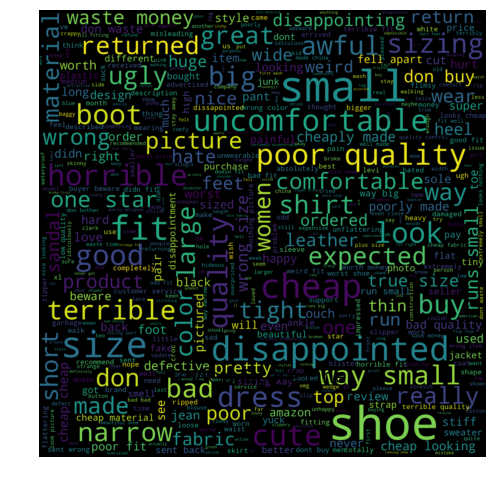

In [22]:
show_wordcloud(cluster1["summaryClean"][0], title = "Review Score One")

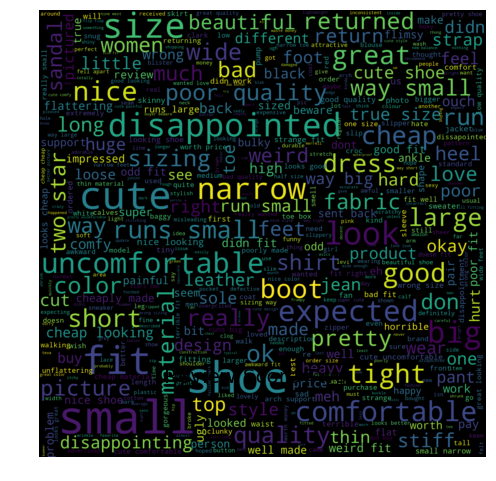

In [24]:
show_wordcloud(cluster1["summaryClean"][1] , title = "Review Score Two")

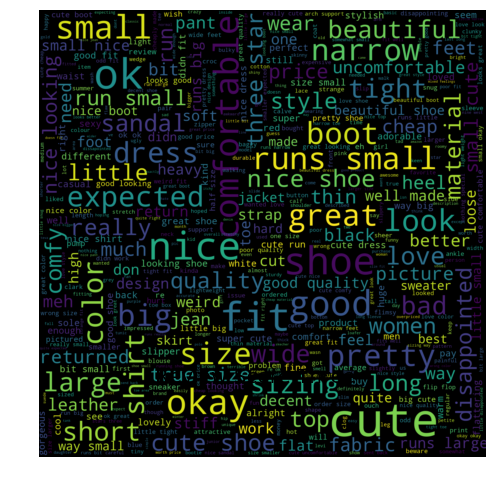

In [26]:
show_wordcloud(cluster1["summaryClean"][2], title = "Review Score Three")

In [55]:
a

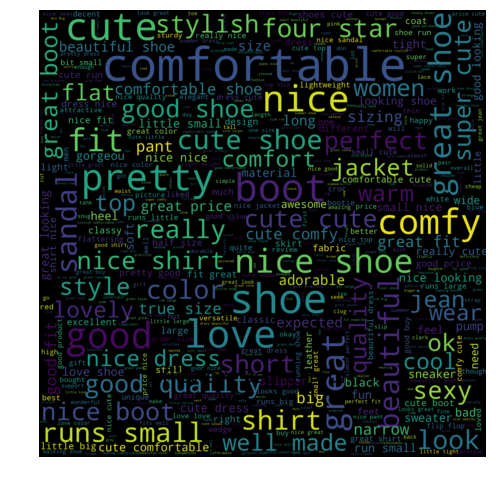

In [28]:
show_wordcloud(cluster1["summaryClean"][3], title = "Review Score Four")

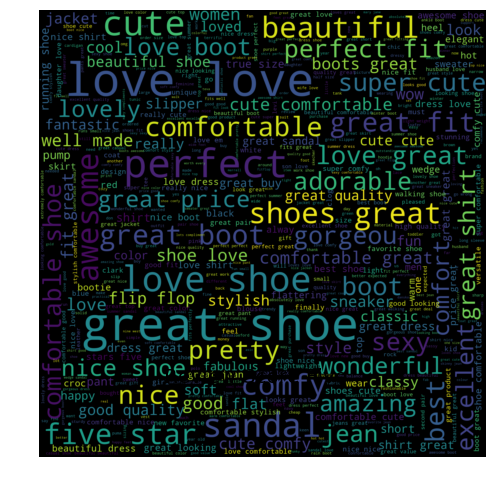

In [30]:
show_wordcloud(cluster1["summaryClean"][4], title = "Review Score Five")